In [1]:
from importlib import reload
import pathlib
import os
import sys
import time
from pprint import pprint
import numba
from numba import jit,prange
numba.set_num_threads(6)

In [2]:
this_path = pathlib.Path('.').parent.absolute()
src_path = os.path.join(this_path, '..')
sys.path.insert(0, src_path)

In [3]:
import dnashapeparams as dsp
import find_motifs as fm
import numpy as np
import inout
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
import cvlogistic
from scipy.stats import sem
from scipy import optimize as opt

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

In [5]:
import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
glmnet = rpackages.importr('glmnet')

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
params = [
    "test/BRCA1_input/BRCA1_30_bp_height_train_4.fa.EP",
    "test/BRCA1_input/BRCA1_30_bp_height_train_4.fa.HelT",
    "test/BRCA1_input/BRCA1_30_bp_height_train_4.fa.MGW",
    "test/BRCA1_input/BRCA1_30_bp_height_train_4.fa.ProT",
    "test/BRCA1_input/BRCA1_30_bp_height_train_4.fa.Roll",
]
param_names = [
    "EP",
    "HelT",
    "MGW",
    "ProT",
    "Roll",
]
this_dist = inout.manhattan_distance
search_method = "brute"
in_file = "test/BRCA1_input/BRCA1_30_bp_height_train_4.txt"
kmer = 15
ignorestart = 2
ignoreend = 2
threshold_perc = 0.05
thresh_sd_from_mean = 2.0
threshold_seeds = 2.0
threshold_match = 2.0
seeds_per_seq_thresh = 1
seeds_per_seq = 2
num_seeds = 5000
rc = False

Here, we read in the shape information to a list. The list will contain inout.FastaFile objects.

**Maybe I should remake this as a dictionary with shape names as keys and the inout.FastaFile objects as values.**

In [8]:
# all_params = [
#     fm.read_parameter_file(x) for x in params
# ]

In [9]:
# all_params

In [10]:
# dir(all_params[0])

In [11]:
# all_params[0].data

In [12]:
# dir(all_params[0].data['peak_8_0'])

In [13]:
# all_params[0].data['peak_8_0'].seq

In [14]:
# records = inout.SeqDatabase()
# records.read(in_file, int)

In [15]:
# records

In [16]:
# dir(records)

In [17]:
# records.get_values()

In [18]:
# np.max(records.get_values())

In [19]:
# np.mean(records.get_values())

In [20]:
# fm.seqs_per_bin(records)

In [21]:
# just for speed of testing code, sub-sample the records
# rand_idxs = np.random.choice(range(len(records)), len(records), False)

In [22]:
# records = inout.SeqDatabase()
# records.read(in_file, int, rand_idxs)

In [23]:
# len(records)

Here we add each shape parameter to each record.

When finished, this nested loop will result in each record's value having a corresponding set of params. That set of params is stored as a dictionary, with the param name as key and sequence as values.

In [24]:
# add parameter values for each element of records
# for name, record in zip(records.names, records):
#     # loop over shape parameter information, adding the parameter's info
#     #  to this element of records
#     for i, (param, param_name) in enumerate(zip(all_params, param_names)):
#         record.add_shape_param(
#             dsp.ShapeParamSeq(
#                 param_name,
#                 param.pull_entry(name).seq,
#             ),
#         )
#         record.metric = this_dist

In [25]:
# records[0]

In [26]:
# dir(records.params[0])

In [27]:
# len(records.params)

In [28]:
# len(records.values)

In [29]:
# records.params[0].names

In [30]:
# records.params[0].data

In [31]:
# dir(records.params[0].data["EP"])

In [32]:
# records.params[0].data["EP"].get_values()

In [33]:
# len(records.params)

In [34]:
inout = reload(inout)
dsp = reload(dsp)
fm = reload(fm)

In [35]:
shape_fname_dict = {n:fn for n,fn in zip(param_names, params)}
rec_db = inout.RecordDatabase(in_file, shape_fname_dict)

In [36]:
rec_db.records_per_bin()

{0: 1340, 1: 424}


In [37]:
rec_db.determine_center_spread()
rec_db.normalize_shape_values()
rec_db.compute_windows(wsize=15)
rec_db.initialize_weights()

In [38]:
rec_db.set_initial_thresholds(
    threshold_sd_from_mean = thresh_sd_from_mean
)

In [39]:
rec_db.thresholds.mean()

3.8995269910871206

In [40]:
# rec_db.windows.reshape((1764, 15*5, 41))[0,:,0]

In [41]:
# rec_db.windows[0,:,:,0].flatten() == rec_db.windows.reshape((1764, 15*5, 41))[0,:,0]

In [42]:
# class Distance(keras.layers.Layer):
#     def __init__(self, units=1, input_dim=32):
#         super(Distance, self).__init__()
#         self.w = self.add_weight(
#             shape=(input_dim, units),
#             initializer="random_normal",
#             trainable=True,
#         )
#         self.b = self.add_weight(
#             shape=(units,),
#             initializer="zeros",
#             trainable=True,
#         )

#     def call(self, inputs):
#         return tf.matmul(inputs, self.w) + self.b


# class Distance(tf.keras.Model):
#     def __init__(self, dist_func, kernel_size, filters):
#         self.dist = dist_func
        
#         super(ResnetIdentityBlock, self).__init__(name='')
#         filters1, filters2, filters3 = filters

#         self.conv2a = tf.keras.layers.Conv2D(filters1, (1, 1))
#         self.bn2a = tf.keras.layers.BatchNormalization()

#         self.conv2b = tf.keras.layers.Conv2D(filters2, kernel_size, padding='same')
#         self.bn2b = tf.keras.layers.BatchNormalization()

#         self.conv2c = tf.keras.layers.Conv2D(filters3, (1, 1))
#         self.bn2c = tf.keras.layers.BatchNormalization()

#     def call(self, input_tensor, training=False):
#     x = self.conv2a(input_tensor)
#     x = self.bn2a(x, training=training)
#     x = tf.nn.relu(x)

#     x = self.conv2b(x)
#     x = self.bn2b(x, training=training)
#     x = tf.nn.relu(x)

#     x = self.conv2c(x)
#     x = self.bn2c(x, training=training)

#     x += input_tensor
#     return tf.nn.relu(x)

In [43]:
# def manhattan_distance(x,y):
#     return(K.sum(K.abs(x-y)))

# def mi(y_true, y_pred):

In [44]:
test_R = 1501
test_W = 25
test_weights = rec_db.weights[test_R,:,:,test_W].flatten()
test_thresh = rec_db.thresholds[test_R,test_W]
test_target = np.append(test_weights, test_thresh)
win_shapes = rec_db.windows[test_R,:,:,test_W]
ref_shapes = rec_db.windows
test_y = rec_db.y

In [45]:
print(test_weights.shape)
print(test_target.shape)

(75,)
(76,)


In [46]:
# ref_shapes[test_R,:,test_W] == win_shapes

In [47]:
# query_in = layers.Input(shape=win_shapes.shape)
# ref_in = layers.Input(shape=ref_shapes.shape)

In [48]:
info = {
    "NFeval": 0,
    "value": [],
    "eval": [],
}

fm.optimize_weights_worker(
    test_target,
    win_shapes,
    ref_shapes,
    test_y,
    inout.manhattan_distance,
    info
)

-0.07535251431845122

In [49]:
# info = {
#     "NFeval": 0,
#     "value": [],
#     "eval": [],
# }

# final_opt = opt.minimize(
#     fm.optimize_weights_worker,
#     test_target,
#     args = (
#         win_shapes,
#         ref_shapes,
#         test_y,
#         inout.manhattan_distance,
#         info,
#     ),
#     method = "trust-constr",
#     constraints = {"type": "eq", "fun": constr}
# )

In [50]:
# final_opt

In [ ]:
rec_num = 50
rec_subset = np.random.permutation(rec_db.X.shape[0])[:rec_num]
results = fm.mp_optimize_weights(
    rec_db,
    inout.manhattan_distance,
    rec_subset,
    p = 6,
)

/home/jeremy/src/miniconda3/envs/motifer/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/home/jeremy/src/miniconda3/envs/motifer/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/home/jeremy/src/miniconda3/envs/motifer/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/home/jeremy/src/miniconda3/envs/motifer/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacob

In [ ]:
len(results)

In [ ]:
first_res_dict = results[0].get()

In [ ]:
first_res_dict

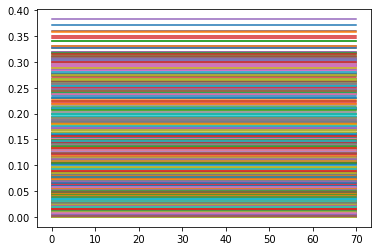

In [62]:
rec_list = []
win_list = []
eval_list = []
mi_list = []
diff_list = []

for res in results:
    this_dict = res.get()
    this_mi = this_dict['opt_info']['value']
    this_eval = this_dict['opt_info']['eval']
    this_rec = this_dict['r_idx']
    this_win = this_dict['w_idx']
    this_diff = (
        np.max(this_dict['opt_info']['value']) -
        np.min(this_dict['opt_info']['value'])
    )
    diff_list.append(this_diff)
    mi_list.append(this_mi)
    eval_list.append(this_eval)
    rec_list.append(this_rec)
    win_list.append(this_win)
    plt.plot(
        this_eval,
        this_mi,
        label="Rec: {}, Win: {}".format(this_rec, this_win),
    )

In [63]:
np.max(diff_list)

0.0

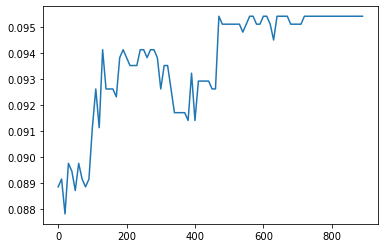

In [71]:
plt.plot(info["eval"], info["value"]);
plt.show();

In [196]:
# records.determine_center_spread()
# records.normalize_params()

In [197]:
# records.params[0].data["EP"].get_values()

In [198]:
# the vectors attribute contains a list of sliding windows for each
#  record
# records.vectors = []
# records.vectors

In [240]:
# records.pre_compute_windows(
#     wsize = kmer,
#     wstart = ignorestart,
#     wend = ignoreend
# )

In [241]:
# records.params[0].sliding_windows(15)

In [242]:
# records.params[0][5:10].data

In [243]:
# one list of windows for each record
# len(records.vectors)

In [244]:
# records.params[0].names

In [245]:
# a list of windows for each record
# len(records.vectors[0])

In [246]:
# records.vectors[0][0].data

In [247]:
# records.vectors[0][0].data['EP'].get_values()

In [248]:
# len(records.vectors[0][0].data['EP'].get_values())

In [249]:
# mean, stdev = fm.find_initial_threshold(
#     records.random_subset_by_class(
#         threshold_perc,
#     ),
#     seeds_per_seq_thresh,
# )
# threshold_seeds = max(mean - threshold_seeds*stdev, 0)
# threshold_match = max(mean - threshold_match*stdev, 0)

In [250]:
# threshold_seeds

In [251]:
# threshold_match

In [252]:
# for motif in records.vectors[0][0]:
#     print(motif.name, motif)

In [253]:
# len(records.vectors[0][0].as_vector())

In [254]:
# len(records.vectors[0])

In [255]:
# records.shape_vectors_to_2d_array()
# records.shape_vectors_to_3d_array()

In [256]:
# print(records.flat_windows.shape)

In [257]:
# @jit(nopython=True, parallel=True)
# def fast_generate_peak_array(data, threshold, results, N, W):
#     """Does same thing as generate_peak_vector, but hopefully faster
    
#     Args:
#     -----
#     data : np.array
#         Array of shape (N,L*P,W), where N is the number of records,
#         L*P is the window size times the number of parameters, and
#         W is the number of windows for each record.
#     threshold : float
#         Minimum distance to consider a match.
#     results : 2d np.array
#         Array of shape (N*W,N), where N*W is the number of records times the number
#         of windows for each record and N is the number of records.
#         This array should be populated with zeros.
#     """
    
#     for n in prange(N):
#         for w in range(W):
            
#             row_idx = n*W + w
#             q_seq = data[n,:,w]
            
#             for r_n in range(N):
#                 for r_w in range(W):
#                     ref_seq = data[r_n,:,r_w]
                    
#                     distance = fast_manhattan_distance(q_seq, ref_seq)
#                     if distance < threshold:
#                         # if distance is low enough, set the index for this seed, and this ref to 1
#                         results[row_idx, r_n] = 1
#                         break
                        
# def fast_evaluate_seeds(recs, possible_motifs, threshold, rc):
#     """Gets hits for each potential motif to the input data and adds
#     mutual information and other helpful tidbits.
    
#     Args:
#     -----
#     records : inout.SeqDatabase object
    
#     """
    
#     recs.shape_vectors_to_3d_array()

#     rec_num,_,win_num = recs.flat_windows.shape
#     seed_num = rec_num*win_num
#     hits = np.zeros((seed_num, rec_num))
    
#     # hits is modified in place
#     fast_generate_peak_array(
#         recs.flat_windows,
#         threshold,
#         hits,
#         rec_num,
#         win_num,
#     )
    
#     seeds = []
#     for i in range(seed_num):
#         seed_info = {}
#         these_hits = hits[i,:]
#         seed_info['mi'] = records.mutual_information(these_hits)
#         seed_info['seed'] = possible_motifs[i]
#         seed_info['discrete'] = these_hits
#         seed_info['threshold'] = threshold
#         seeds.append(seed_info)
        
#     return(seeds)

Here, I could mess with testing seeds_per_seq and number arguments to see how high we need to go with these args to get good performance.

In [54]:
if search_method == "greedy":
    possible_motifs = fm.greedy_search2(
        records,
        threshold_seeds,
        num_seeds,
        seeds_per_seq,
    )
elif search_method == "brute":
    possible_motifs = [
        motif
        # a_seq is now a list of windows sliced from a given dictionary of params
        for i,a_seq in enumerate(records.iterate_through_precompute())
        # motif is a single window from the list of windows
        for motif in a_seq
    ]

In [55]:
len(possible_motifs)

74088

In [56]:
possible_motifs[0].data

{'EP': <dnashapeparams.ShapeParamSeq at 0x7fbedffb56a0>,
 'HelT': <dnashapeparams.ShapeParamSeq at 0x7fbedffb5700>,
 'MGW': <dnashapeparams.ShapeParamSeq at 0x7fbedffb5400>,
 'ProT': <dnashapeparams.ShapeParamSeq at 0x7fbedffb50d0>,
 'Roll': <dnashapeparams.ShapeParamSeq at 0x7fbedffb51c0>}

In [57]:
len(possible_motifs[0].data['EP'])

15

In [58]:
possible_motifs[0].as_vector()

array([ 0.85231105, -0.4660118 , -0.9872092 ,  0.32498191, -0.20847896,
        0.88296972,  0.89523319, -0.09810775, -0.11650295,  0.63770035,
        0.61317342, -1.03626308, -1.25700551, -1.66169996, -0.92589186,
        0.22693147,  0.37191547, -1.04010257,  0.09455478, -0.36561181,
        1.25442674, -2.02347228, -0.10716208, -1.91000654, -0.05673287,
        1.1157464 , -0.76904554,  1.27964135,  0.80686745,  1.03379892,
        1.67711216,  0.23698324, -1.29429308, -1.60419424,  0.51042544,
        0.74740868,  0.61980232,  1.1849162 ,  1.22137516, -0.07291792,
       -0.92970348, -1.51304684, -1.6406532 , -1.367211  , -0.71094972,
        0.17254415, -0.73051159, -0.41455412,  0.56020827, -0.15685832,
        0.71482576,  1.2055682 ,  0.09859666,  0.10531916,  1.2526257 ,
        0.37870079, -0.6027841 , -1.1854007 , -1.14506571, -0.69689909,
        1.46340406, -0.97560271, -0.6504018 , -1.23455898,  2.86658573,
        0.22282284, -0.11442254,  3.88434411, -0.23486732,  0.47

In [59]:
possible_motifs[0].data['EP'].get_values()

array([ 0.85231105, -0.4660118 , -0.9872092 ,  0.32498191, -0.20847896,
        0.88296972,  0.89523319, -0.09810775, -0.11650295,  0.63770035,
        0.61317342, -1.03626308, -1.25700551, -1.66169996, -0.92589186])

In [60]:
possible_motifs[0].data['HelT'].get_values()

array([ 0.22693147,  0.37191547, -1.04010257,  0.09455478, -0.36561181,
        1.25442674, -2.02347228, -0.10716208, -1.91000654, -0.05673287,
        1.1157464 , -0.76904554,  1.27964135,  0.80686745,  1.03379892])

Let's limit the analysis to 10000 possible motifs for now

In [61]:
start_time = time.time()
all_fast_seeds = fm.fast_evaluate_seeds(records, possible_motifs, threshold_match, rc, this_dist)
end_time = time.time()
f_eval_seeds_t = end_time - start_time
print(f_eval_seeds_t)

892.5395514965057


In [62]:
all_fast_seeds

[{'mi': 0.0012142487819390719,
  'seed': <dnashapeparams.ShapeParams at 0x7fbedffb5670>,
  'discrete': array([1., 0., 0., ..., 0., 0., 0.]),
  'threshold': 62.1729856596269},
 {'mi': 0.006565242132693418,
  'seed': <dnashapeparams.ShapeParams at 0x7fbee0498a60>,
  'discrete': array([1., 0., 0., ..., 1., 0., 0.]),
  'threshold': 62.1729856596269},
 {'mi': 0.014212788413839987,
  'seed': <dnashapeparams.ShapeParams at 0x7fbedffb5ac0>,
  'discrete': array([1., 0., 0., ..., 1., 1., 0.]),
  'threshold': 62.1729856596269},
 {'mi': 0.03586066478811185,
  'seed': <dnashapeparams.ShapeParams at 0x7fbee0498eb0>,
  'discrete': array([1., 0., 0., ..., 1., 0., 0.]),
  'threshold': 62.1729856596269},
 {'mi': 0.02876789226557381,
  'seed': <dnashapeparams.ShapeParams at 0x7fbf4472c310>,
  'discrete': array([1., 1., 0., ..., 1., 1., 0.]),
  'threshold': 62.1729856596269},
 {'mi': 0.024443810893013132,
  'seed': <dnashapeparams.ShapeParams at 0x7fbee0498be0>,
  'discrete': array([1., 0., 0., ..., 1., 1

In [63]:
this_records = records
other_records = records

For each potential motif, the evaluate seeds function compares the potential motif to each sequence in the ground truth data to determine whether it has a match to the potential motif. If it does, the index for this sequence in the ground truth data is given a 1. Otherwise its index is given a 0.

Then, the ground truth vector is compared to this match vector to calculate their mutual information.

**This is a good target for adjusting things to use `jit(nopython=True, parallel=True)`.**

Within `evaluate_seeds`, `generate_peak_vector` is called. Within `generate_peak_vector`, we calculate the distance between every possible motif and each sequence in the input data. If any distance meets our threshold, we call the comparison a match, and assign a 1 to the index of our match vector corresponding to the same index of our precomputed windows vector from our input data's precomputed windows.



In [64]:
start_time = time.time()
all_seeds = fm.evaluate_seeds(this_records, possible_motifs, threshold_match, rc)
end_time = time.time()
eval_seeds_t = end_time - start_time
print(eval_seeds_t)

3155.8864254951477


In [65]:
eval_seeds_t/f_eval_seeds_t

3.535850506796844

In [66]:
all_seeds

[{'mi': 0.0012142487819390719,
  'seed': <dnashapeparams.ShapeParams at 0x7fbedffb5670>,
  'discrete': array([ True, False, False, ..., False, False, False]),
  'threshold': 62.1729856596269},
 {'mi': 0.006565242132693418,
  'seed': <dnashapeparams.ShapeParams at 0x7fbee0498a60>,
  'discrete': array([ True, False, False, ...,  True, False, False]),
  'threshold': 62.1729856596269},
 {'mi': 0.014212788413839987,
  'seed': <dnashapeparams.ShapeParams at 0x7fbedffb5ac0>,
  'discrete': array([ True, False, False, ...,  True,  True, False]),
  'threshold': 62.1729856596269},
 {'mi': 0.03586066478811185,
  'seed': <dnashapeparams.ShapeParams at 0x7fbee0498eb0>,
  'discrete': array([ True, False, False, ...,  True, False, False]),
  'threshold': 62.1729856596269},
 {'mi': 0.02876789226557381,
  'seed': <dnashapeparams.ShapeParams at 0x7fbf4472c310>,
  'discrete': array([ True,  True, False, ...,  True,  True, False]),
  'threshold': 62.1729856596269},
 {'mi': 0.024443810893013132,
  'seed': <

In [67]:
same = []
for i,seed_info in enumerate(all_seeds):
    f_seed_info = all_fast_seeds[i]
    same.append(np.all(seed_info['discrete'] == f_seed_info['discrete']))
    
print(np.all(same))

True


Within the aic_seeds function, we sort the list of seed dictionaries, "all_seeds" my mutual information. Then, for each seed dictionary in that list, check in its AIC is < 0 (2 * delta_k 0 2*n*MI_this_seed < 0), where delta_k is the length of the seed sequence. If the AIC < 0, then evaluate using conditional mutual information whether this potentially good seed is better than any of the seeds that were considered good prior to this one. If it improves the model, add to list of good seeds

In [68]:
good_seeds = []
for seed in all_fast_seeds:
    passed = fm.aic_seeds([seed], this_records)
    if len(passed) > 0:
        good_seeds.append(seed)

In [69]:
good_seeds

[{'mi': 0.0876852709805363,
  'seed': <dnashapeparams.ShapeParams at 0x7fbedffb9190>,
  'discrete': array([1., 1., 1., ..., 1., 0., 1.]),
  'threshold': 62.1729856596269},
 {'mi': 0.1096365919435984,
  'seed': <dnashapeparams.ShapeParams at 0x7fbedffb93d0>,
  'discrete': array([1., 1., 1., ..., 1., 0., 1.]),
  'threshold': 62.1729856596269},
 {'mi': 0.10302603011303937,
  'seed': <dnashapeparams.ShapeParams at 0x7fbedffb9610>,
  'discrete': array([1., 1., 1., ..., 1., 0., 1.]),
  'threshold': 62.1729856596269},
 {'mi': 0.11174627342337948,
  'seed': <dnashapeparams.ShapeParams at 0x7fbedffb9850>,
  'discrete': array([1., 1., 1., ..., 1., 0., 1.]),
  'threshold': 62.1729856596269},
 {'mi': 0.09460720329085662,
  'seed': <dnashapeparams.ShapeParams at 0x7fbedffb9a90>,
  'discrete': array([1., 1., 1., ..., 1., 0., 1.]),
  'threshold': 62.1729856596269},
 {'mi': 0.08538298374731983,
  'seed': <dnashapeparams.ShapeParams at 0x7fbedffb9cd0>,
  'discrete': array([1., 1., 1., ..., 1., 0., 1.])

In [70]:
len(all_seeds[0]['seed'].as_vector())

75

In [71]:
len(good_seeds)

26284

Now that seeds have been filtered by AIC and CMI, we do logit regression to do what?

### Making x vals for logit reg

Here, generate_match_vector is looking for every "good_seed" in the input sequence data for matches.

It accepts a single motif (seed) to search for within every k-long window in every sequence in the input data. For each original sequence in the input data, it keeps the minimum distance between the query seed and that sequence and outputs that as an array.

In [72]:
X = [
    fm.generate_match_vector(this_records, this_motif['seed'], rc=rc)
    for this_motif in good_seeds
]

X is a list of i arrays len(good_seeds) long. Each array in X is j, len(inputdata), long, and contains the minimum distance between good_seed i and input sequence j.

We convert X to a 2d array, standardize the distances, then regress our input data's ground truth on X.

So what we're really regressing here is the ground truth categories versus the minimal distance between each seed and the category in the input data.

In [73]:
X = np.stack(X, axis=1)

In [74]:
X.shape

(1764, 26284)

In [75]:
X = StandardScaler().fit_transform(X)

In [76]:
X

array([[-6.83436229, -6.15961775, -6.25625413, ..., -0.19771579,
        -0.35481117, -0.63804919],
       [-0.77013149, -0.73605845, -0.8290704 , ..., -1.51535098,
        -1.44236516, -1.86200746],
       [-0.81869456, -0.9987746 , -1.24558786, ..., -0.04214111,
         0.15809501, -0.25588638],
       ...,
       [-0.81657023, -0.87627882, -1.06682846, ...,  0.54522255,
         0.24532315,  0.46201411],
       [ 0.78787324,  0.79438401,  0.52735666, ...,  0.22155557,
         0.55368983,  0.33634795],
       [-0.30989731, -0.3455513 , -0.19015503, ..., -7.34315537,
        -7.54145017, -8.15472127]])

In [77]:
y = this_records.get_values()

In [ ]:
%timeit -n 1 -r 1 clf = LogisticRegressionCV(Cs = 100, cv = 5, multi_class = "multinomial", penalty="l1", solver="saga", max_iter=10000).fit(X,y)

In [ ]:
clf

In [52]:
dir(clf)

['C_',
 'Cs',
 'Cs_',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_predict_proba_lr',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'class_weight',
 'classes_',
 'coef_',
 'coefs_paths_',
 'cv',
 'decision_function',
 'densify',
 'dual',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'intercept_scaling',
 'l1_ratio_',
 'l1_ratios',
 'l1_ratios_',
 'max_iter',
 'multi_class',
 'n_features_in_',
 'n_iter_',
 'n_jobs',
 'penalty',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'random_state',
 '

In [53]:
# Each class of scores must be Fold rows by Cs columns
clf.scores_[1].shape

(5, 100)

In [54]:
first_class = list(clf.scores_.keys())[0]

In [55]:
all_scores = clf.scores_[first_class]

In [56]:
# Take mean of folds for each C we tested here
CV_avg = np.mean(all_scores, axis=0)
CV_sem = sem(all_scores, axis=0)
# Now get the max score's index to find the C that yielded the best score
best_score_idx = np.argmax(CV_avg)

In [57]:
best_score_idx

41

In [58]:
CV_avg[best_score_idx]

0.9699620139067731

In [59]:
CV_sem[best_score_idx]

0.006911351545892924

In [60]:
# here Mike is calling it 1se, probably because he was originally
#  using 1se. Now it's really 2se. I saw something to this effect
#  when looking through Mike's 2019 notes.
score_1se = CV_avg[best_score_idx] - 2*CV_sem[best_score_idx]
best_c_idx = np.argmax(CV_avg >= score_1se)

In [61]:
best_c_idx

31

In [62]:
best_c = clf.Cs_[best_c_idx]

In [63]:
best_c

0.03199267137797385

In [64]:
clf.Cs_

array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97702356e-03, 5.99484250e-03, 7.22080902e-03,
       8.69749003e-03, 1.04761575e-02, 1.26185688e-02, 1.51991108e-02,
       1.83073828e-02, 2.20513074e-02, 2.65608778e-02, 3.19926714e-02,
       3.85352859e-02, 4.64158883e-02, 5.59081018e-02, 6.73415066e-02,
       8.11130831e-02, 9.77009957e-02, 1.17681195e-01, 1.41747416e-01,
       1.70735265e-01, 2.05651231e-01, 2.47707636e-01, 2.98364724e-01,
       3.59381366e-01, 4.32876128e-01, 5.21400829e-01, 6.28029144e-01,
       7.56463328e-01, 9.11162756e-01, 1.09749877e+00, 1.32194115e+00,
       1.59228279e+00, 1.91791026e+00, 2.31012970e+00, 2.78255940e+00,
      

In [65]:
clf_f = LogisticRegression(
    C = best_c,
    multi_class = "multinomial",
    penalty = "l1",
    solver = "saga",
    max_iter = 10000,
).fit(X,y)

In [66]:
clf_f

LogisticRegression(C=0.03199267137797385, max_iter=10000,
                   multi_class='multinomial', penalty='l1', solver='saga')

In [67]:
dir(clf_f)

['C',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_predict_proba_lr',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'class_weight',
 'classes_',
 'coef_',
 'decision_function',
 'densify',
 'dual',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'intercept_scaling',
 'l1_ratio',
 'max_iter',
 'multi_class',
 'n_features_in_',
 'n_iter_',
 'n_jobs',
 'penalty',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'random_state',
 'score',
 'set_params',
 'solver',
 'sparsify',
 'tol',
 'verbose',
 'w

In [68]:
coefs = clf_f.coef_
coefs.shape

(1, 136)

So, what l1-penalized logistic regression has allowed us to do is to narrow down, from our initial seeds that passed the MI, AIC, CMI criteria, a set of seeds that are most informative on the ground truth scores.

In [69]:
coefs

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.2811673 ,  0.        ,
         0.        ,  0.        , -0.22655442,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.11243475,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.37847789,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03879723,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.07564474,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [70]:
good_seed_index = np.argwhere(np.max(abs(coefs), axis=0) > 0).flatten()

In [71]:
good_seed_index

array([  8,  12,  24,  40,  45,  62,  69,  75,  82,  88,  92,  94,  99,
       102, 104, 106, 108, 119, 127, 132])

In [72]:
len(good_seed_index)

20

In [73]:
final_good_seeds = [
    good_seeds[idx]
    for idx in good_seed_index
]

In [74]:
final_good_seeds[0]

{'mi': 0.3965917185213159,
 'seed': <dnashapeparams.ShapeParams at 0x7fb04459f2e0>,
 'discrete': array([False, False,  True, ...,  True, False, False]),
 'threshold': 58.25138472667949}

In [75]:
[s['threshold'] for s in final_good_seeds]

[58.25138472667949,
 58.25138472667949,
 58.25138472667949,
 58.25138472667949,
 58.25138472667949,
 58.25138472667949,
 58.25138472667949,
 58.25138472667949,
 58.25138472667949,
 58.25138472667949,
 58.25138472667949,
 58.25138472667949,
 58.25138472667949,
 58.25138472667949,
 58.25138472667949,
 58.25138472667949,
 58.25138472667949,
 58.25138472667949,
 58.25138472667949,
 58.25138472667949]

In [76]:
for motif in final_good_seeds:
    fm.add_seed_metadata(this_records, motif)

add_seed_metadata adds some entropy information and "enrichment" infomration to each seed in final_good_seeds.

calculate_enrichment is defined in inout.py within the SeqDatabase class.

calculate_enrichment compares every record in a SeqDatabase object to the given vector of 0/1 indicators of whether a given seed does not match (0) or does match (1) the record within SeqDatabase.

The SeqDatabase object contains many records for which there is no peak. Counts for no-match/match to these are stored as values to the 0 key in the dictionary for this seed.

SeqDatabase records for which there is a peak are looked at for matches to this seed as well, and those counts are stored as values to the 1 key in the dictionary for this seed.

For the count vectors, their values can be thought of as a two-way table, so for the 0 key, its value is a two-way table, with values 

[(number of records without peak that match this seed), (number of records with peak that match this seed), (number of records without peak that DO NOT match this seed), (number of records with peak that DO NOT match this seed)].

Then, the 1 key for each seed is the same information, just permuted to look from the perspective of the records WITH peaks, 

[(number of records with peak that match this seed),(number of records without peak that match this seed),(number of records with peak that DO NOT match this seed),(number of records without peak that DO NOT match this seed)]

In [77]:
[s['enrichment'] for s in final_good_seeds]

[{0: [102, 364, 1238, 60], 1: [364, 102, 60, 1238]},
 {0: [218, 385, 1122, 39], 1: [385, 218, 39, 1122]},
 {0: [76, 312, 1264, 112], 1: [312, 76, 112, 1264]},
 {0: [180, 387, 1160, 37], 1: [387, 180, 37, 1160]},
 {0: [105, 196, 1235, 228], 1: [196, 105, 228, 1235]},
 {0: [127, 303, 1213, 121], 1: [303, 127, 121, 1213]},
 {0: [225, 360, 1115, 64], 1: [360, 225, 64, 1115]},
 {0: [160, 258, 1180, 166], 1: [258, 160, 166, 1180]},
 {0: [69, 306, 1271, 118], 1: [306, 69, 118, 1271]},
 {0: [178, 314, 1162, 110], 1: [314, 178, 110, 1162]},
 {0: [20, 248, 1320, 176], 1: [248, 20, 176, 1320]},
 {0: [90, 315, 1250, 109], 1: [315, 90, 109, 1250]},
 {0: [227, 376, 1113, 48], 1: [376, 227, 48, 1113]},
 {0: [36, 130, 1304, 294], 1: [130, 36, 294, 1304]},
 {0: [66, 172, 1274, 252], 1: [172, 66, 252, 1274]},
 {0: [179, 311, 1161, 113], 1: [311, 179, 113, 1161]},
 {0: [71, 254, 1269, 170], 1: [254, 71, 170, 1269]},
 {0: [37, 111, 1303, 313], 1: [111, 37, 313, 1303]},
 {0: [70, 274, 1270, 150], 1: [274, 

After this, there's the potential for seed optimization, which Mike says doesn't help much.

Then the final step is where Mike further filters seeds against held out data using conditional mutual information